In [2]:
## Notebook by Ying Meng, (from notebooks/tasks/Task1_GenerateAEs_ZeroKnowledgeModel)
## Modified by Cody Shearer
import os
import sys
module_path = os.path.abspath(os.path.join('../../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(sys.path)
import numpy as np
from matplotlib import pyplot as plt

['', 'C:\\Users\\codyi\\Repositories\\project-athena\\Task1_update\\scripts\\cody_scripts', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\python37.zip', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\DLLs', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib', 'C:\\Users\\codyi\\anaconda3\\envs\\athena', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib\\site-packages', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib\\site-packages\\win32', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib\\site-packages\\win32\\lib', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib\\site-packages\\Pythonwin', 'C:\\Users\\codyi\\anaconda3\\envs\\athena\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\codyi\\.ipython', 'C:\\Users\\codyi\\Repositories\\project-athena\\src']


## (Optional) Prepare a smaller dataset for your experiment

* python example: `tutorials/subsamples.py`
* api: `utils.data.subsampling`

In [6]:
from utils.data import subsampling
from utils.file import load_from_json

# load the configurations for the experiment
data_configs = load_from_json("../../configs/BIM/data-bim-mnist.json")
output_root = "../../data"

# load the full-sized benign samples
file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
X_bs = np.load(file)

# load the corresponding true labels
file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(file)

# get random subsamples
# for MNIST, num_classes is 10
# files "subsamples-mnist-ratio_0.1-xxxxxx.npy" and "sublabels-mnist-ratio_0.1-xxxxxx.npy"
# will be generated and saved at "/results" folder, where "xxxxxx" are timestamps.

subsamples, sublabels = subsampling(data=X_bs,
                                    labels=labels,
                                    num_classes=10,
                                    filepath=output_root,
                                    filename='mnist')

## Update the json file accordingly

1. Copy and paste the generated subsamples to the right place (i.e., defined by `"dir"` in `data-mnist.json`).
2. In the `data-mnist.json`, replace the value of `"bs_file"` with the `"subsamples-mnist-ratio_0.1-xxxxxx.npy"` and the value of `"label_file"` with the `"sublabels-mnist-ratio_0.1-xxxxxx.npy"`.

# Generate adversarial examples
We use `FGSM` as the example.
* python example: `tutorials/craft_adversarial_examples.py`
* main api: `attacks.attack.generate`
* check tunable parameters for each attack in file `attacks/attack.py`.

In [7]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs, save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_configs.get(key)
                            )
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}: {}->{}'.format(attack_configs.get(key).get("description"),
                                        labels[i],
                                        predictions[i]
                                        )
            plt.title(title)
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir,
                "AE-mnist-cnn-clean-bim_eps{}_maxiter{}.npy".format(
                    attack_configs.get(key).get("eps"),
                    attack_configs.get(key).get("max_iter"))
                )
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

>>> Loading model [../../../models/cnn/model-mnist-cnn-clean.h5]...


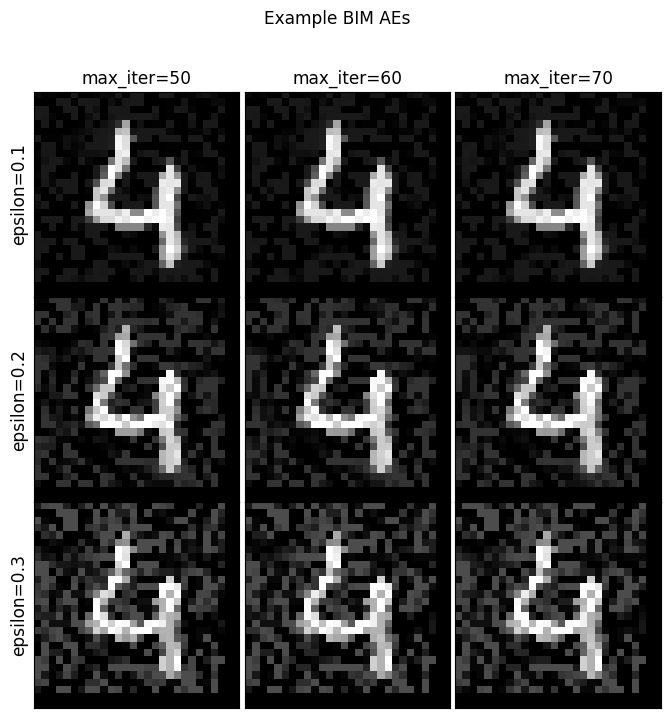

In [74]:
import os

%matplotlib inline
from matplotlib import pyplot as plt

# loading experiment configurations
model_configs = load_from_json("../../configs/BIM/model-mnist.json")
data_configs = load_from_json("../../configs/BIM/data-bim-mnist.json")
attack_configs = load_from_json("../../configs/BIM/attack-bim-mnist.json")

# load labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)
labels = np.asarray([np.argmax(p) for p in labels])

# load list of AEs
ae_list = data_configs.get('ae_files')

# load the benign samples to get dimensions of images
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

# load the targeted model
model_file = os.path.join(model_configs.get("dir"), model_configs.get("um_file"))
model = load_lenet(file=model_file, wrap=True)

fig, axs = plt.subplots(3,3,
                        facecolor='w',
                        figsize=(8,8), dpi=102)

fig.subplots_adjust(hspace=0, wspace=0)

fig.suptitle('Example BIM AEs')

rows = ['epsilon={}'.format(col) for col in [0.1, 0.2, 0.3]]
cols = ['max_iter={}'.format(row) for row in [50, 60, 70]]

# set labels for columns
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

# set labels for rows
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

# plot some adversarial examples and their predictions
for ae_ind, ax in zip(range(len(ae_list)), axs.flatten()):
    # load AE image
    ae_file = os.path.join(data_configs.get('dir'), ae_list[ae_ind])
    data_adv = np.load(ae_file)
    predictions = model.predict(data_adv)
    predictions = np.asarray([np.argmax(p) for p in predictions])
    img = data_adv[0].reshape((img_rows, img_cols))
    # add AE image
    ax.imshow(img, cmap='gray')
    # turn off useless ticks and tick labels
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
fig.savefig('../../figures/example_BIM_AEs.png', dpi=fig.dpi, pad_inches=0, bbox_inches='tight')

## Update the generated adversarial examples in json

* Either add an item for the generated AEs. e.g., assume that we named the generated AE as `"fgsm_eps0.3.npy"`, then add the item as below example, then get your AE list by `data_configs.get("task1_aes")`.

```
"task1_aes" : [
                  "fgsm_eps0.3.npy"
              ]

```


2. Or, create a new json file similar to `"data-mnist.json"`, and replace the whole list for `"ae_files"` with your own list.

# Evaluate the generated AEs
* python example: `tutorials/eval_model.py`
* api: `utils.metrics.error_rate`

In [15]:
from utils.model import load_pool, load_lenet
from utils.metrics import error_rate, get_corrections
from utils.file import load_from_json
from models.athena import Ensemble, ENSEMBLE_STRATEGY
import numpy as np
import pandas as pd

# copied from tutorials/eval_model.py
def evaluate(trans_configs, model_configs, data_configs, attack_configs):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)
    
    # get list of attacks
    attack_list = [attack_configs.get('configs'+str(i)) for i in range(attack_configs.get('num_attacks'))]
        
    # Evaluate AEs.
    ae_list = data_configs.get('ae_files')
    results = np.empty([len(ae_list), 5])
    for ae_ind in range(len(ae_list)):
        ae_file = os.path.join(data_configs.get('dir'), ae_list[ae_ind])
        print(ae_list[ae_ind])
        print(ae_file)
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them laterr
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
        eps = attack_list[ae_ind].get('eps')
        max_iter = attack_list[ae_ind].get('max_iter')
        results[ae_ind]=[err_um, err_ens, err_bl, eps, max_iter]
    
    results_df = pd.DataFrame(results, columns=['UM Error Rate',
                                                'EM Error Rate',
                                                'PGD-ADT Error Rate',
                                                'Epsilon',
                                                'Max_iter'])
    print(results_df.head())
    results_df.to_csv('../../results/bim.csv')

In [16]:
# load experiment configurations
trans_configs = load_from_json("../../configs/BIM/athena-mnist.json")
model_configs = load_from_json("../../configs/BIM/model-mnist.json")
data_configs = load_from_json("../../configs/BIM/data-bim-mnist.json")
attack_configs = load_from_json("../../configs/BIM/attack-bim-mnist.json")

# evaluate
evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         attack_configs=attack_configs)

>>> Loading model [../../../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../../../models/cnn/model-mnist-cnn-clean.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-rotate90.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-affine_vertical_compress.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-morph_erosion.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-augment_samplewise_std_norm.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-cartoon_mean_type1.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-quant_4_clusters.h5]...
>>> Loading model [../../../models/cnn/model-mnist-cnn-distort_x.h5]...
>>> Loading model [../../../models

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter50.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter50.npy]:
[[7.27595939e-12 3.10640701e+08 7.10542899e-15 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.65755031e+07 7.10542899e-15
  1.81898985e-12]
 [9.87168890e+08 7.10542899e-15 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 3.10640700e+08 7.10542899e-15 1.81898985e-12
  3.42202826e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.81898985e-12]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.1_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter60.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter60.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [2.77555819e-17 1.13686866e-13 9.65755031e+07 7.10542899e-15
  1.81898985e-12]
 [9.87168890e+08 7.10542899e-15 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 3.10640700e+08 7.10542899e-15 1.81898985e-12
  3.42202826e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.81898985e-12]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.1_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter70.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.1_maxiter70.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.87168890e+08 7.10542899e-15 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 3.10640700e+08 7.10542899e-15 1.81898985e-12
  3.42202826e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.81898985e-12]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.2_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter50.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter50.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [1.13686866e-13 3.10640700e+08 7.10542899e-15 1.81898985e-12
  3.42202826e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.81898985e-12]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.2_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter60.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter60.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 9.80788675e-02 8.08897877e-02 2.00000000e-01
  5.00000000e+01]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.81898985e-12]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.2_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter70.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.2_maxiter70.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 9.80788675e-02 8.08897877e-02 2.00000000e-01
  5.00000000e+01]
 [9.88877654e-01 9.60566229e-02 7.98786653e-02 2.00000000e-01
  6.00000000e+01]
 [9.49590621e+09 2.77555819e-17 1.13686866e-13 3.42202826e+09
  2.77555819e-17]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.3_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter50.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter50.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 9.80788675e-02 8.08897877e-02 2.00000000e-01
  5.00000000e+01]
 [9.88877654e-01 9.60566229e-02 7.98786653e-02 2.00000000e-01
  6.00000000e+01]
 [9.88877654e-01 9.80788675e-02 7.98786653e-02 2.00000000e-01
  7.00000000e+01]
 [1.13686866e-13 9.49590619e+09 2.77555819e-17 1.81898985e-12
  9.49590621e+09]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.3_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter60.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter60.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 9.80788675e-02 8.08897877e-02 2.00000000e-01
  5.00000000e+01]
 [9.88877654e-01 9.60566229e-02 7.98786653e-02 2.00000000e-01
  6.00000000e+01]
 [9.88877654e-01 9.80788675e-02 7.98786653e-02 2.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 4.40849343e-01 3.61981800e-01 3.00000000e-01
  5.00000000e+01]
 [2.77555819e-17 1.13686866e-13 9.49590619e+09 2.77555819e-17
  1.13686866e-13]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
AE-mnist-cnn-clean-bim_eps0.3_maxi

C:\Users\codyi\Repositories\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


Y predict shape:  1000
989
>>> Evaluating baseline model on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter70.npy], it may take a while...
Y predict shape:  1000
989
>>> Evaluations on [../../data/AE-mnist-cnn-clean-bim_eps0.3_maxiter70.npy]:
[[9.05965622e-01 1.61779575e-02 2.52780586e-02 1.00000000e-01
  5.00000000e+01]
 [9.10010111e-01 1.82002022e-02 2.52780586e-02 1.00000000e-01
  6.00000000e+01]
 [9.18099090e-01 1.71890799e-02 2.52780586e-02 1.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 9.80788675e-02 8.08897877e-02 2.00000000e-01
  5.00000000e+01]
 [9.88877654e-01 9.60566229e-02 7.98786653e-02 2.00000000e-01
  6.00000000e+01]
 [9.88877654e-01 9.80788675e-02 7.98786653e-02 2.00000000e-01
  7.00000000e+01]
 [9.88877654e-01 4.40849343e-01 3.61981800e-01 3.00000000e-01
  5.00000000e+01]
 [9.88877654e-01 4.48938322e-01 3.64004044e-01 3.00000000e-01
  6.00000000e+01]
 [9.49590619e+09 2.77555819e-17 1.13686866e-13 6.87341689e+08
  7.10542899e-15]]
   UM Error Rate  EM Error Rate  P

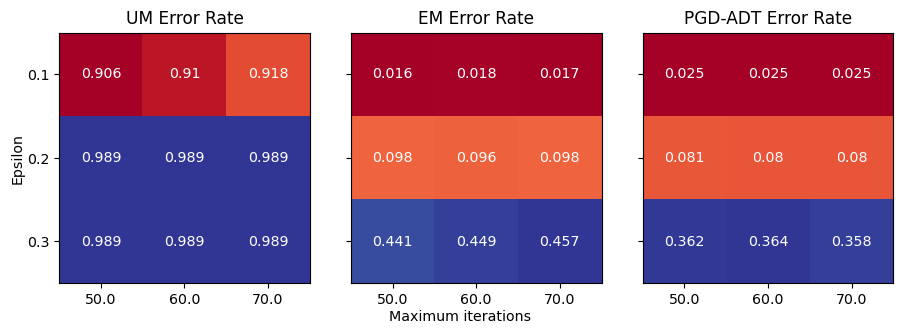

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# read data
df = pd.read_csv('../../results/bim.csv')

# parse data into 3d array accesed by [model][eps][max_iter]
max_iter_values = df['Max_iter'].unique()
eps_values = df['Epsilon'].unique() 
models = ['UM Error Rate', 'EM Error Rate', 'PGD-ADT Error Rate']

results = np.empty([len(models), len(max_iter_values),len(eps_values)])

for k, model in enumerate(models):
    for i, max_iter in enumerate(max_iter_values):
        for j, eps in enumerate(eps_values):
            df_at_above = df.loc[(df['Max_iter'] == max_iter ) & (df['Epsilon'] == eps)]
            results[k][j][i] = df_at_above[model]

# plot evaluations
fig, axs = plt.subplots(1,3,
                        facecolor='w',
                        sharey=True, 
                        figsize=(9,3), dpi=102)

for (i, model), ax in zip(enumerate([UM,EM,PG]), axs.flatten()):
    # plot image
    ax.imshow(results[i], cmap ="RdYlBu")
    # set title
    ax.set_title(models[i])
    # set xticks
    ax.set_xticks(range(len(max_iter_values.tolist())))
    ax.set_xticklabels(max_iter_values.tolist())
    # set y ticks
    ax.set_yticks(range(len(eps_values.tolist())))
    ax.set_yticklabels(eps_values.tolist())
    # annotate heatmap
    for x in range(len(max_iter_values.tolist())):
        for y in range(len(eps_values.tolist())):
            text = ax.text(y, x, round(model[x, y], 3),
                       ha="center", va="center", color="w")
    

fig.text(0.5, -0.03, 'Maximum iterations', ha='center')
fig.text(0.01, 0.5, 'Epsilon', va='center', rotation='vertical')
plt.tight_layout()
fig.savefig('../../figures/bim_evaluation.png', dpi=fig.dpi, pad_inches=0, bbox_inches='tight')